In [1]:
import numpy as np
import mittens
import os
import csv
from gensim.models import Word2Vec,FastText
import gensim.downloader as api
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict


class EmbeddingLayer():
    def __init__(self, mode='word2vec'):
        self.type = mode
        self.word2vec_model = Word2Vec(vector_size=300, min_count=1)

        self.word_embeddings = []
        self.X = []
        self.y = []

    def fit_transform(self, data, labels):
        self.data = data
        self.labels = labels
        
        if self.type == 'word2vec':
            self.word2vec()
        elif self.type == 'glove':
            self.glove()
        elif self.type == 'fasttext':
            self.fasttext()
        else:
            raise ValueError('Invalid embed mode')
        
        maxlen = 0
        for i in range(len(self.X)):
            self.X[i] = np.array(self.X[i])
            maxlen = max(maxlen, self.X[i].shape[0])

        self.maxlen = maxlen
        
        for i in range(len(self.X)):
            self.X[i] = np.pad(self.X[i], ((0,maxlen - self.X[i].shape[0]),(0,0)), 'constant')
        
        self.y = self.create_tag_map(self.labels)
        self.y = pad_sequences(self.y,maxlen=maxlen,padding='post',value=0,dtype='int32')

        self.X = np.array(self.X).astype('float32')
        self.y = np.array(self.y).astype('float32')

        return self.X, self.y
    __call__ = fit_transform

    def transform(self, data, labels):
        word_embeddings = []
        
        for i in range(len(data)):
            sentence = data[i]
            embeddings = []
            for word in sentence:
                try:
                    if self.type == 'word2vec':
                        embeddings.append(self.word2vec_model.wv.get_vector(word))
                    elif self.type == 'glove':
                        embeddings.append(self.glove_model(word))
                    elif self.type == 'fasttext':
                        embeddings.append(self.fasttext_model.wv.get_vector(word))
                    else:
                        raise ValueError('Invalid embed mode')
                except KeyError:
                    embeddings.append(np.random.rand(300)*0.1)
            word_embeddings.append(embeddings)
        
        for i in range(len(word_embeddings)):
            word_embeddings[i] = word_embeddings[i][:self.maxlen]
            word_embeddings[i] = np.pad(word_embeddings[i], ((0,self.maxlen - len(word_embeddings[i])),(0,0)), 'constant')
        word_embeddings = np.array(word_embeddings).astype('float32')
        
        if labels is not None:
            y = self.create_tag_map(labels)
            y = pad_sequences(y,maxlen=self.maxlen,padding='post',value=0,dtype='int32')
            y = np.array(y).astype('float32')
        else:
            y = None

        return word_embeddings, y
                        
    def word2vec(self):
        self.word2vec_model.build_vocab(self.data)
        self.word2vec_model.wv.vectors_lockf = np.ones(shape=(len(self.word2vec_model.wv.index_to_key),1))
        self.word2vec_model.wv.intersect_word2vec_format(
            './embeddings/GoogleNews-vectors-negative300.bin',
            binary=True,
            lockf=1.0
        )
        self.word2vec_model.train(self.data, total_examples=self.word2vec_model.corpus_count, epochs=self.word2vec_model.epochs, compute_loss=True)

        for sentence in self.data:
            embeddings = []
            for word in sentence:
                embeddings.append(self.word2vec_model.wv.get_vector(word))
            self.word_embeddings.append(embeddings)

        self.X = self.word_embeddings
    
    def glove(self):
        # create a pre-trained word to embedding dictionary
        def glove2dict(glove_filename):
            with open(glove_filename, encoding='utf-8') as f:
                reader = csv.reader(f, delimiter=' ',quoting=csv.QUOTE_NONE)
                embed = {line[0]: np.array(list(map(float, line[1:])))
                        for line in reader}
            return embed

        glove_path = './embeddings/glove/glove.6B.300d.txt'
        if os.path.exists(glove_path):
           glove_dict = glove2dict(glove_path)
        else: 
             glove_model = api.load("glove-wiki-gigaword-300")
             glove_dict = {word: glove_model[word] for word in glove_model.index_to_key}

        corpus=self.data
        corpus_tokens=defaultdict(int)
        for a in corpus:
            for b in a: 
                corpus_tokens[b.lower()]+=1

        vocab = list(corpus_tokens.keys())
        corpus_doc = [' '.join(a) for a in corpus]

        vectorizer = CountVectorizer(ngram_range=(1,1), vocabulary=vocab)
        X = vectorizer.fit_transform(corpus_doc)
        co_occurrence_matrix = (X.T * X)
        co_occurrence_matrix.setdiag(0)
        co_occurrence_matrix = co_occurrence_matrix.toarray()

        mittens_model = mittens.Mittens(n=len(list(glove_dict.values())[0]), max_iter=1000)
        new_embeddings = mittens_model.fit(
            co_occurrence_matrix,
            vocab=vocab,
            initial_embedding_dict=glove_dict
        )
        token_to_idx = {token: index for index, token in enumerate(vocab)}
        new_glove_embedding_dict={}
        for a in token_to_idx:
            new_glove_embedding_dict[a]=new_embeddings[token_to_idx[a]]
        self.glove_model=new_glove_embedding_dict

    def fasttext(self):
        corpus=self.data
        model = FastText(corpus, vector_size=300, window=5, workers=4,sg=1, epochs=1000, min_count=1)
        self.fasttext_model=model

        for sentence in self.data:
            embeddings = []
            for word in sentence:
                embeddings.append(self.fasttext_model.wv.get_vector(word))
            self.word_embeddings.append(embeddings)
        self.X = self.word_embeddings

    def create_tag_map(self,labels):
        y_un = list(chain(*labels))
        y_un = list(set(y_un))
        tag_map = {}
        for i in range(len(y_un)):
            tag_map[y_un[i]] = (i+1)
        
        for label in labels:
            for i in range(len(label)):
                label[i] = tag_map[label[i]]
        return labels

In [14]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, SimpleRNN, LSTM, GRU, Dense
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping
from keras.losses import sparse_categorical_crossentropy
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


def macro_f1(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.reshape(y_pred,[-1])
    y_true = tf.reshape(y_true,[-1])
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    f1 = f1_score(tf.keras.backend.eval(y_true), tf.keras.backend.eval(y_pred), average='macro')
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    return f1, acc


class NERModel():
    def __init__(self, num_classes, num_features=None, layer=SimpleRNN, embed='word2vec', **kwargs):
        super(NERModel, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.num_features = num_features

        self.embedding_layer = EmbeddingLayer(embed)
        self.layer = layer
        
        self.seq = Sequential()
        self.seq.add(self.layer(units=64,return_sequences=True,use_bias=True))
        self.seq.add(Dense(1024, activation='relu', use_bias=True))
        self.seq.add(Dense(256, activation='relu', use_bias=True))
        self.seq.add(Dense(64, activation='relu', use_bias=True))
        self.seq.add(Dense(num_classes, activation='softmax', use_bias=True))

        self.batch_size = None
        self.model = None
    
    def build_model(self):
        X = Input(shape=(None,self.num_features))
        Y = self.seq(X)
        zeros = tf.zeros(shape=(tf.shape(Y)[0],tf.shape(Y)[1],1), dtype=tf.float32)
        Y = tf.concat([Y,zeros], axis=-1)
        self.model = Model(inputs=X, outputs=Y)

    def compile_model(self):
        self.model.compile(
            optimizer=Adam(learning_rate=self.lr),
            loss=sparse_categorical_crossentropy,
            metrics=[macro_f1, 'accuracy'],
            run_eagerly=True
        )

    def fit(self, X, y, X_val, y_val, lr, epochs=50, batch_size=32, patience=None):
        if(self.num_features is None):
            self.num_features = X.shape[1]
        
        self.batch_size = batch_size
        
        self.lr = lr
        self.epochs = epochs

        X, y = self.embedding_layer.fit_transform(X, y)
        X_val, y_val = self.embedding_layer.transform(X_val, y_val)

        if ((patience is None) or (patience>int(0.5*epochs))):
            patience = 0.1*epochs

        self.build_model()
        self.compile_model()
        
        self.model.fit(
            x=X,
            y=y, 
            epochs=epochs,
            validation_data=(X_val, y_val),
            verbose=1,
            shuffle=True,
            callbacks=[EarlyStopping(monitor='val_loss',patience=patience, restore_best_weights=True)],
            batch_size=self.batch_size
        )

        self.generate_plots()

    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_t, y_t):
        X,y = self.embedding_layer.transform(X_t, y_t)
        res = self.model.evaluate(X, y, verbose=0)
        f1 = res[1]
        acc = res[2]
        return f1, acc
    
    def generate_plots(self):
        if self.model is not None:
            self._plot_losses(
                self.model.history.history['loss'],
                'Training Loss',
                self.model.history.history['val_loss'],
                'Validation Loss'
            )
            self._plot_accuracy(
                self.model.history.history['accuracy'],
                'Training Accuracy',
                self.model.history.history['val_accuracy'],
                'Validation Accuracy'
            )

    def _plot_losses(self, tr_loss, tr_label, val_loss=None, val_label=None):
        plt.figure(figsize=(10,8))
        plt.plot(tr_loss, label=tr_label)

        if(val_loss is not None):
            plt.plot(val_loss, label=val_label)

        plt.xlabel('Epochs',fontsize=12)
        plt.ylabel('Loss',fontsize=12)
        plt.legend()
        plt.show()

    def _plot_accuracy(self, tr_acc, tr_label, val_acc=None, val_label=None):
        plt.figure(figsize=(10,8))
        plt.plot(tr_acc, label=tr_label)

        if(val_acc is not None):
            plt.plot(val_acc, label=val_label)

        plt.xlabel('Epochs',fontsize=12)
        plt.ylabel('Accuracy',fontsize=12)
        plt.legend()
        plt.show()

In [15]:
import json

with open('./Task1_data/NER_train.json', 'r') as file:
    train_data = json.load(file)
with open('./Task1_data/NER_val.json', 'r') as file:
    val_data = json.load(file)
with open('./Task1_data/NER_test.json', 'r') as file:
    test_data = json.load(file)

In [16]:
data_train = []
labels_train = []
for sample in train_data.items():
    data_train.append(sample[1]['text'].split())
    labels_train.append(sample[1]['labels'])

data_val = []
labels_val = []
for sample in val_data.items():
    data_val.append(sample[1]['text'].split())
    labels_val.append(sample[1]['labels'])

data_test = []
labels_test = []
for sample in test_data.items():
    data_test.append(sample[1]['text'].split())
    labels_test.append(sample[1]['labels'])

In [17]:
num_classes = len(list(set(list(chain(*labels_train)))))

Epoch 1/20
63/63 [==============================] - 32s 513ms/step - loss: 0.6342 - macro_f1: 0.4649 - accuracy: 0.8591 - val_loss: 0.3812 - val_macro_f1: 0.5044 - val_accuracy: 0.9168
Epoch 2/20
63/63 [==============================] - 32s 517ms/step - loss: 0.3410 - macro_f1: 0.5088 - accuracy: 0.9221 - val_loss: 0.3275 - val_macro_f1: 0.5354 - val_accuracy: 0.9261
Epoch 3/20
63/63 [==============================] - 32s 512ms/step - loss: 0.2780 - macro_f1: 0.5783 - accuracy: 0.9343 - val_loss: 0.2808 - val_macro_f1: 0.6051 - val_accuracy: 0.9351
Epoch 4/20
63/63 [==============================] - 32s 515ms/step - loss: 0.2372 - macro_f1: 0.6332 - accuracy: 0.9425 - val_loss: 0.2583 - val_macro_f1: 0.6462 - val_accuracy: 0.9417
Epoch 5/20
63/63 [==============================] - 32s 505ms/step - loss: 0.2170 - macro_f1: 0.6590 - accuracy: 0.9468 - val_loss: 0.2544 - val_macro_f1: 0.6608 - val_accuracy: 0.9436
Epoch 6/20
63/63 [==============================] - 32s 504ms/step - loss: 

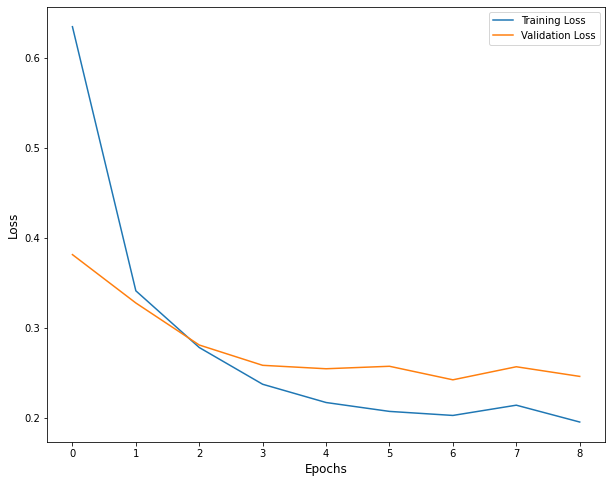

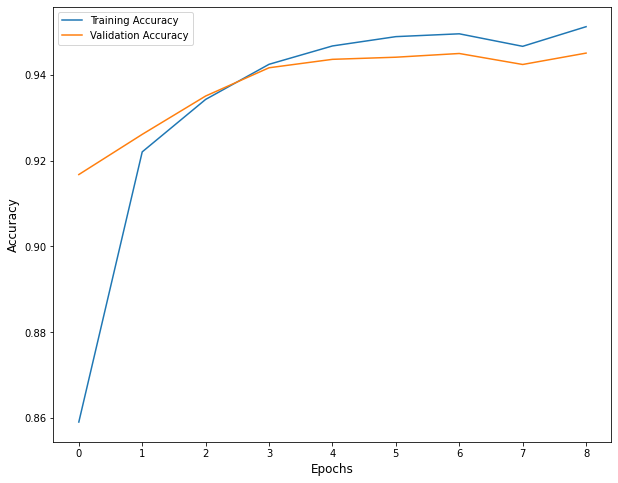

In [18]:
rnn_model_w2v = NERModel(num_classes=num_classes, num_features=300, layer=SimpleRNN)
rnn_model_w2v.fit(data_train, labels_train, data_val, labels_val, lr=0.002, epochs=20, batch_size=128)

In [19]:
f1_rnn_w2v,acc_rnn_w2v = rnn_model_w2v.evaluate(data_test, labels_test)
print("-------------------- Vanilla RNN Model ---------------------")
print(f"Macro F1: {f1_rnn_w2v}, Accuracy: {acc_rnn_w2v}")

30/30 [==============================] - 1s 33ms/step
-------------------- Vanilla RNN Model ---------------------
Macro F1: 0.6554586291313171, Accuracy: 0.9334337115287781


Epoch 1/20
63/63 [==============================] - 36s 564ms/step - loss: 0.7226 - macro_f1: 0.4592 - accuracy: 0.8408 - val_loss: 0.3484 - val_macro_f1: 0.5107 - val_accuracy: 0.9226
Epoch 2/20
63/63 [==============================] - 38s 604ms/step - loss: 0.3084 - macro_f1: 0.5216 - accuracy: 0.9274 - val_loss: 0.3019 - val_macro_f1: 0.5482 - val_accuracy: 0.9280
Epoch 3/20
63/63 [==============================] - 38s 612ms/step - loss: 0.2493 - macro_f1: 0.5988 - accuracy: 0.9396 - val_loss: 0.2578 - val_macro_f1: 0.6292 - val_accuracy: 0.9402
Epoch 4/20
63/63 [==============================] - 39s 619ms/step - loss: 0.2208 - macro_f1: 0.6423 - accuracy: 0.9461 - val_loss: 0.2407 - val_macro_f1: 0.6463 - val_accuracy: 0.9434
Epoch 5/20
63/63 [==============================] - 38s 600ms/step - loss: 0.2016 - macro_f1: 0.6685 - accuracy: 0.9506 - val_loss: 0.2305 - val_macro_f1: 0.6655 - val_accuracy: 0.9469
Epoch 6/20
63/63 [==============================] - 37s 596ms/step - loss: 

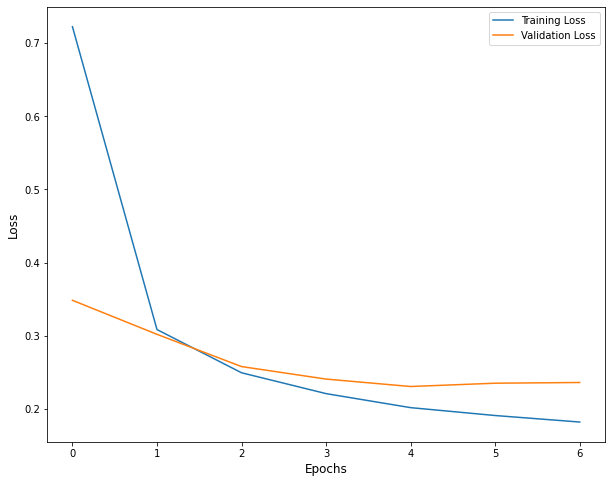

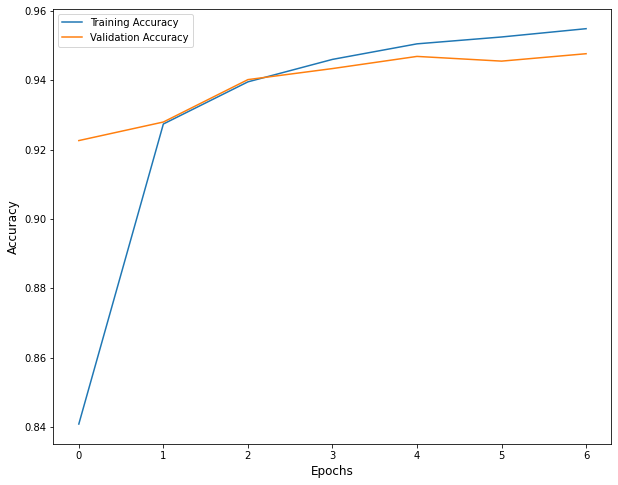

In [20]:
lstm_model_w2v = NERModel(num_classes=num_classes, num_features=300, layer=LSTM)
lstm_model_w2v.fit(data_train, labels_train, data_val, labels_val, lr=0.002, epochs=20, batch_size=128)

In [21]:
f1_lstm_w2v,acc_lstm_w2v = lstm_model_w2v.evaluate(data_test, labels_test)
print("------------------------ LSTM Model ------------------------")
print(f"Macro F1: {f1_lstm_w2v}, Accuracy: {acc_lstm_w2v}")

30/30 [==============================] - 1s 48ms/step
------------------------ LSTM Model ------------------------
Macro F1: 0.6501052975654602, Accuracy: 0.9348487257957458


Epoch 1/20
63/63 [==============================] - 39s 604ms/step - loss: 0.7281 - macro_f1: 0.4616 - accuracy: 0.8455 - val_loss: 0.3610 - val_macro_f1: 0.5090 - val_accuracy: 0.9205
Epoch 2/20
63/63 [==============================] - 37s 589ms/step - loss: 0.2883 - macro_f1: 0.5493 - accuracy: 0.9302 - val_loss: 0.2698 - val_macro_f1: 0.6034 - val_accuracy: 0.9354
Epoch 3/20
63/63 [==============================] - 35s 564ms/step - loss: 0.2260 - macro_f1: 0.6345 - accuracy: 0.9441 - val_loss: 0.2417 - val_macro_f1: 0.6560 - val_accuracy: 0.9445
Epoch 4/20
63/63 [==============================] - 34s 543ms/step - loss: 0.1994 - macro_f1: 0.6731 - accuracy: 0.9506 - val_loss: 0.2446 - val_macro_f1: 0.6678 - val_accuracy: 0.9437
Epoch 5/20
63/63 [==============================] - 34s 544ms/step - loss: 0.1880 - macro_f1: 0.6887 - accuracy: 0.9532 - val_loss: 0.2250 - val_macro_f1: 0.6739 - val_accuracy: 0.9476
Epoch 6/20
63/63 [==============================] - 34s 546ms/step - loss: 

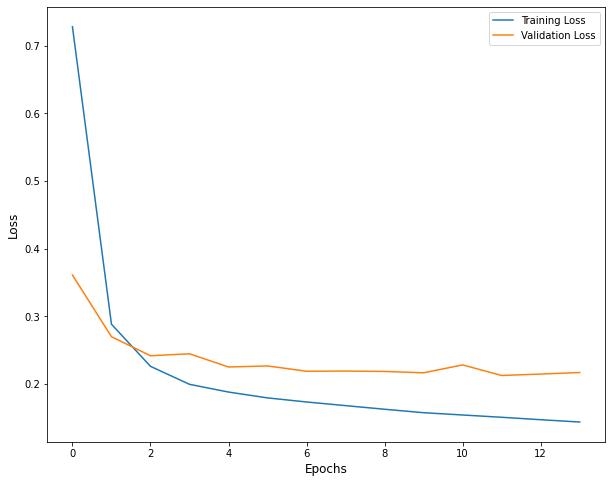

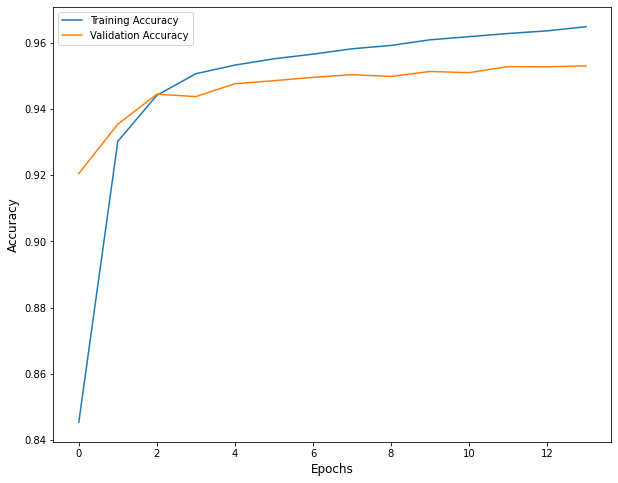

In [22]:
gru_model_w2v = NERModel(num_classes=num_classes, num_features=300, layer=GRU)
gru_model_w2v.fit(data_train, labels_train, data_val, labels_val, lr=0.002, epochs=20, batch_size=128)

In [23]:
f1_gru_w2v,acc_gru_w2v = gru_model_w2v.evaluate(data_test, labels_test)
print("------------------------ GRU Model -------------------------")
print(f"Macro F1: {f1_gru_w2v}, Accuracy: {acc_gru_w2v}")

30/30 [==============================] - 1s 44ms/step
------------------------ GRU Model -------------------------
Macro F1: 0.6744858026504517, Accuracy: 0.9399970173835754


In [ ]:
rnn_model_glove = NERModel(num_classes=num_classes, num_features=300, layer=SimpleRNN, embed='glove')
rnn_model_glove.fit(data_train, labels_train, data_val, labels_val, lr=0.001, epochs=20, batch_size=64)

In [ ]:
f1_rnn_glove,acc_rnn_glove = rnn_model_glove.evaluate(data_test, labels_test)
print("-------------------- Vanilla RNN Model ---------------------")
print(f"Macro F1: {f1_rnn_glove}, Accuracy: {acc_rnn_glove}")

In [ ]:
lstm_model_glove = NERModel(num_classes=num_classes, num_features=300, layer=LSTM, embed='glove')
lstm_model_glove.fit(data_train, labels_train, data_val, labels_val, lr=0.001, epochs=20, batch_size=64)

In [ ]:
f1_lstm_glove,acc_lstm_glove = lstm_model_glove.evaluate(data_test, labels_test)
print("------------------------ LSTM Model ------------------------")
print(f"Macro F1: {f1_lstm_glove}, Accuracy: {acc_lstm_glove}")

In [ ]:
gru_model_glove = NERModel(num_classes=num_classes, num_features=300, layer=GRU, embed='glove')
gru_model_glove.fit(data_train, labels_train, data_val, labels_val, lr=0.001, epochs=20, batch_size=64)

In [ ]:
f1_gru_glove,acc_gru_glove = gru_model_glove.evaluate(data_test, labels_test)
print("------------------------ GRU Model -------------------------")
print(f"Macro F1: {f1_gru_glove}, Accuracy: {acc_gru_glove}")

In [24]:
rnn_model_ft = NERModel(num_classes=num_classes, num_features=300, layer=SimpleRNN, embed='fasttext')
rnn_model_ft.fit(data_train, labels_train, data_val, labels_val, lr=0.002, epochs=20, batch_size=128)

KeyboardInterrupt: 

In [ ]:
f1_rnn_ft,acc_rnn_ft = rnn_model_ft.evaluate(data_test, labels_test)
print("-------------------- Vanilla RNN Model ---------------------")
print(f"Macro F1: {f1_rnn_ft}, Accuracy: {acc_rnn_ft}")

In [ ]:
lstm_model_ft = NERModel(num_classes=num_classes, num_features=300, layer=LSTM, embed='fasttext')
lstm_model_ft.fit(data_train, labels_train, data_val, labels_val, lr=0.002, epochs=20, batch_size=128)

In [ ]:
f1_lstm_ft,acc_lstm_ft = lstm_model_ft.evaluate(data_test, labels_test)
print("------------------------ LSTM Model ------------------------")
print(f"Macro F1: {f1_lstm_ft}, Accuracy: {acc_lstm_ft}")

In [ ]:
gru_model_ft = NERModel(num_classes=num_classes, num_features=300, layer=GRU, embed='fasttext')
gru_model_ft.fit(data_train, labels_train, data_val, labels_val, lr=0.002, epochs=20, batch_size=128)

In [ ]:
f1_gru_ft,acc_gru_ft = gru_model_ft.evaluate(data_test, labels_test)
print("------------------------ GRU Model -------------------------")
print(f"Macro F1: {f1_gru_ft}, Accuracy: {acc_gru_ft}")